# Emotional AI: EDA

Anaysis by Frank Flavell

## Guiding EDA Questions

[**Descriptive Statistics**](#1)

**How many utterances in total?**

* There are 102,980.0 utterances in total.

**What is the minimum and mazimum length of utterances after cleaning?**

* The longest utterance has 260.0 words
* The shortest utterance has 1.0 words

**What is the average word count per utterance?**

* The average word count is 11.6 words per utterance

**What is the distribution of Utterances by length?**

<img src="images/emotion_ai_dist_utter_length.png" width="600" height="600" align="left"/>


[**Word Frequency**](#2)

**What are the most frequent words?**

<img src="images/emotion_ai_most_frequent_words.png" width="500" height="400" align="left"/>


**How does removing stop words affect the most frequent words?**

Removing stop words seems to remove words that could be relevant for classifying emotion, but it isn't clear the impact of the change until we model.

[**Class Imbalance Check**](#3)

**How many utterances per emotion? What does the class imbalance look like?**

<img src="images/emotion_ai_class_imbalance2.png" width="500" height="400" align="left"/>

  * 0: No emotion: 85,573
  * 1: Anger: 1,022
  * 2: Disgust: 353
  * 3: Fear: 174
  * 4: Happiness: 12,885
  * 5: Sadness: 1,150
  * 6: Surprise: 1,823

[**Combining Datasets to Address Class Imbalance**](#4)

**How does the class imbalance change after including the additional data from Reddit and Emotion AI datasets?

**How many words per emotion?**

**How does the number of words per emotion compare with the number of words in each NRC emotion lexicon?

**What are the most frequent words per emotion?**

# Package Import

In [2]:
# import external libraries
import pandas as pd
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re #regex
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Configure matplotlib for jupyter.
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Import

In [18]:
#Import cleaned data from pickle
df = pd.read_pickle('data/dialogue_lowered_contractions.pickle')

In [19]:
df.head()

,dialogue,topic,emotion,type
0,the kitchen stinks.,1,2,3
1,i will throw out the garbage.,1,0,4
2,"so dick, how about getting some coffee for ton...",1,4,3
3,coffee? i do not honestly like that kind of st...,1,2,4
4,"come on, you can at least try a little, beside...",1,0,3


# <span id="1"></span>1. Descriptive Statistics
#### [Return Contents](#0)

* There are 102,980.0 utterances in total
* The longest document has 260.0 words
* The shortest document has 1.0 words
* The average word count is 11.6 words per utterance

In [20]:
# count the common length of description
df['utter_len'] = df.dialogue.apply(lambda x: len(x.split(" ")))

In [21]:
df.head(2)

,dialogue,topic,emotion,type,utter_len
0,the kitchen stinks.,1,2,3,3
1,i will throw out the garbage.,1,0,4,6


In [22]:
df.utter_len.describe()

print("There are {} utterances in total".format(df.utter_len.describe()['count']))
print("The longest document has {} words".format(df.utter_len.describe()['max']))
print("The shortest document has {} words".format(df.utter_len.describe()['min']))
print("The average word count is {} words per utterance".format(round(df.utter_len.describe()['mean'], 1)))

There are 102980.0 utterances in total
The longest document has 260.0 words
The shortest document has 1.0 words
The average word count is 11.6 words per utterance


Text(0, 0.5, 'Number of utterances')

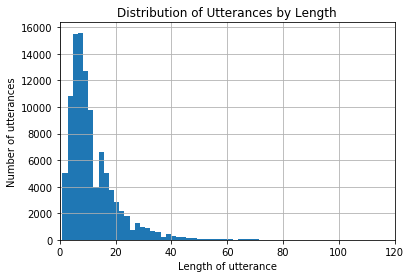

In [23]:
# examining the distribution of the description lengths
df.utter_len.hist(bins = 140)
plt.xlim([0, 120])
plt.title('Distribution of Utterances by Length')
plt.xlabel('Length of utterance')
plt.ylabel('Number of utterances')

# <span id="2"></span>2. Word Frequency
#### [Return Contents](#0)

## Identify The Most Frequent Words

There are a lot of stop words in the list of most frequent words in thedescriptions.  We will need to remove the stop words to get closer to isolating the most relevant keywords in the descriptions.

In [24]:
# getting the word frequency of the original utterance
word_freq = df.dialogue.str.split(expand=True).stack().value_counts()

In [25]:
word_freq[:20]

i       53704
you     41447
the     38451
to      32190
is      30631
a       27530
it      18801
and     16717
have    16126
do      15093
not     14154
of      13924
that    13677
in      12495
are     12361
for     12159
will    10724
what    10078
we       9804
your     9377
dtype: int64

Text(0, 0.5, 'Frequency')

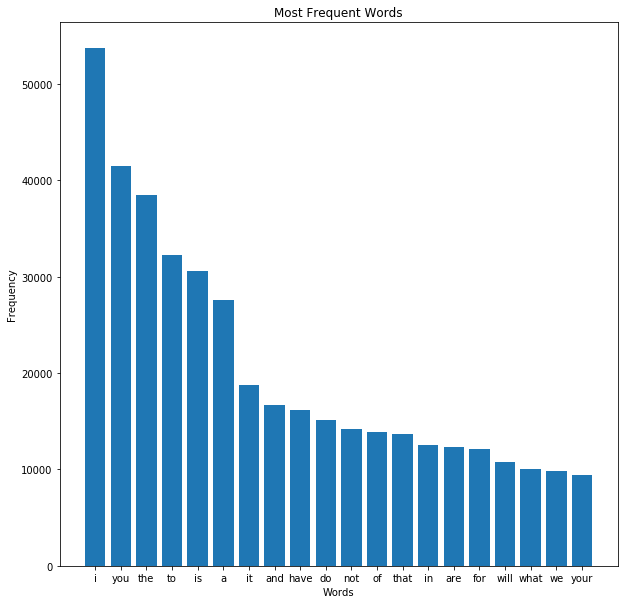

In [26]:
word_freq_top_20 = word_freq[:20]
word_freq_top_20 = dict(word_freq_top_20)
plt.figure(figsize=(10,10))
plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')

## Most Frequent Word After StopWord Removal

In [27]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [28]:
df['utter_cleaned'] = df['dialogue'].apply(clean_text)

In [29]:
df.head()

,dialogue,topic,emotion,type,utter_len,utter_cleaned
0,the kitchen stinks.,1,2,3,3,kitchen stinks
1,i will throw out the garbage.,1,0,4,6,throw garbage
2,"so dick, how about getting some coffee for ton...",1,4,3,9,dick getting coffee tonight
3,coffee? i do not honestly like that kind of st...,1,2,4,10,coffee honestly like kind stuff
4,"come on, you can at least try a little, beside...",1,0,3,12,come least try little besides cigarette


In [30]:
# getting the word frequency of the original utterance
word_freq_clean = df.utter_cleaned.str.split(expand=True).stack().value_counts()

In [32]:
word_freq_clean[:20]

like      7114
would     6713
yes       6236
think     4672
well      4647
good      4549
know      4348
get       4264
go        3945
one       3696
see       3672
right     3620
really    3514
want      3301
please    3265
time      3243
oh        3064
take      2931
much      2922
need      2830
dtype: int64

## Compare Original with Cleaned

After comparing the original utterance with the cleaned version, we may want to be more selective with our stop words than using the standard stopwords included in NLTK.  Some of the utterances lose words that could be useful in classifying emotion.

In [34]:
df.head(30)

,dialogue,topic,emotion,type,utter_len,utter_cleaned
0,the kitchen stinks.,1,2,3,3,kitchen stinks
1,i will throw out the garbage.,1,0,4,6,throw garbage
2,"so dick, how about getting some coffee for ton...",1,4,3,9,dick getting coffee tonight
3,coffee? i do not honestly like that kind of st...,1,2,4,10,coffee honestly like kind stuff
4,"come on, you can at least try a little, beside...",1,0,3,12,come least try little besides cigarette
5,what is wrong with that? cigarette is the thin...,1,1,1,13,wrong cigarette thing go crazy
6,"not for me, dick.",1,0,1,4,dick
7,are things still going badly with your housegu...,1,0,2,8,things still going badly houseguest
8,getting worse. now he is eating me out of hous...,1,1,1,64,getting worse eating house home tried talking ...
9,"leo, i really think you are beating around the...",1,0,3,36,leo really think beating around bush guy know ...


## Most Frequent Angry Words

In [48]:
angry_df = df[df.emotion == 1]

In [50]:
angry_df.head()

,dialogue,topic,emotion,type,utter_len,utter_cleaned
5,what is wrong with that? cigarette is the thin...,1,1,1,13,wrong cigarette thing go crazy
8,getting worse. now he is eating me out of hous...,1,1,1,64,getting worse eating house home tried talking ...
70,"no, the steak was recommended, but it is not v...",1,1,1,11,steak recommended fresh
72,so what? it is not fresh and i am not happy ab...,1,1,1,13,fresh happy
74,"no, thank you.",1,1,4,3,thank


In [53]:
word_freq_angry = angry_df.utter_cleaned.str.split(expand=True).stack().value_counts()
word_freq_angry[:20]

cannot    80
get       68
really    64
oh        63
like      57
know      56
time      56
would     55
going     51
want      48
go        48
think     44
never     37
take      34
one       33
day       33
well      32
way       31
work      30
tell      29
dtype: int64

Text(0, 0.5, 'Frequency')

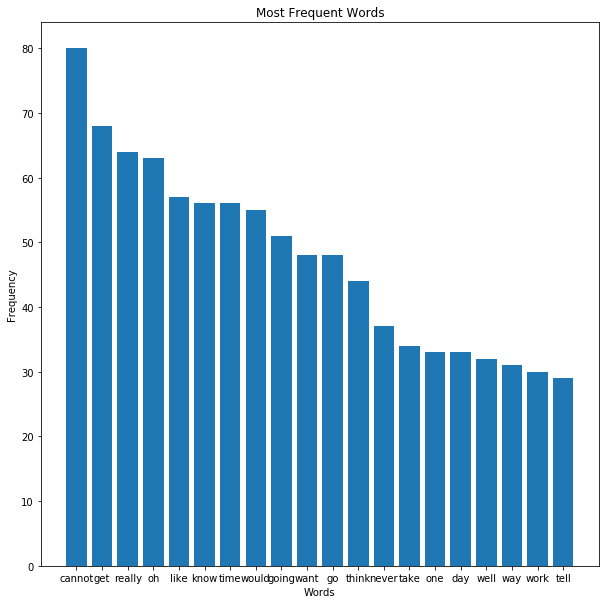

In [57]:
word_freq_top_20 = word_freq_angry[:20]
word_freq_top_20 = dict(word_freq_top_20)
plt.figure(figsize=(10,10))
plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')

## Most Frequenct Disgust Words

In [62]:
def emo_freq(df, emo, num):
    emo_df = df[df.emotion == emo]
    word_frequent = emo_df.utter_cleaned.str.split(expand=True).stack().value_counts()
    return word_frequent[:num]

In [63]:
disgust_freq = emo_freq(df, 2, 20)
disgust_freq

like        38
think       34
really      33
hate        30
oh          21
know        18
would       18
get         17
cannot      17
time        16
well        15
sick        14
terrible    14
people      14
bad         13
going       12
one         11
awful       11
always      10
many        10
dtype: int64

In [85]:
def freq_graph(frequent, title, num):
    word_freq_top_20 = frequent[:num]
    word_freq_top_20 = dict(word_freq_top_20)
    plt.figure(figsize=(10,10))
    plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')

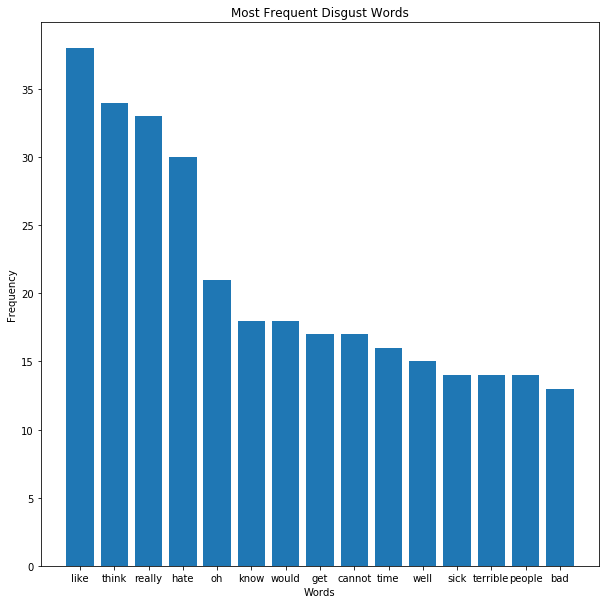

In [88]:
freq_graph(disgust_freq, 'Most Frequent Disgust Words', 15)

## Most Frequent Fear Words

In [89]:
fear_freq = emo_freq(df, 3, 20)
fear_freq

get         21
know        16
scared      15
oh          14
cannot      12
think       11
nervous     11
yes          9
afraid       9
really       8
need         8
call         8
like         8
home         8
looking      7
let          7
well         7
anything     6
little       6
time         6
dtype: int64

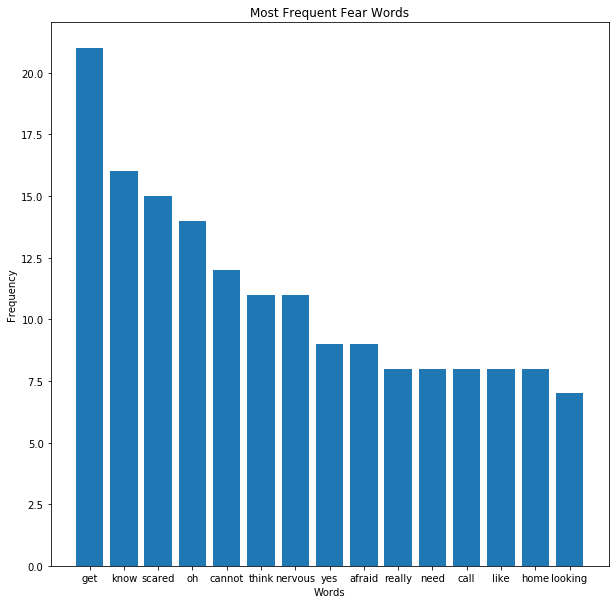

In [90]:
freq_graph(fear_freq, 'Most Frequent Fear Words', 15)

## Most Frequent Happy Words

In [79]:
happy_freq = emo_freq(df, 4, 20)
happy_freq

thank     1460
good      1320
like      1014
thanks     959
great      914
would      725
yes        685
much       664
really     655
see        620
well       567
go         543
oh         541
nice       516
us         495
let        458
sounds     451
think      429
time       424
sure       415
dtype: int64

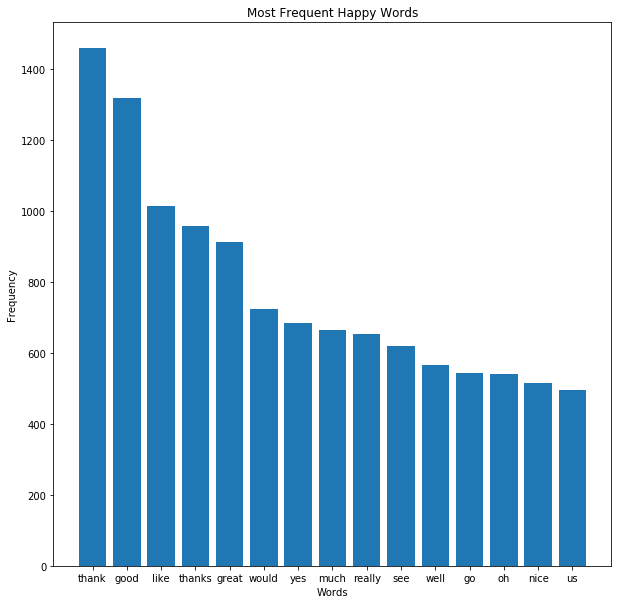

In [91]:
freq_graph(happy_freq, 'Most Frequent Happy Words', 15)

# Most Frequent Sad Words

In [81]:
sad_freq = emo_freq(df, 5, 20)
sad_freq

sorry     364
know      102
oh         99
afraid     88
really     86
cannot     76
well       64
sir        62
would      51
feel       43
right      42
time       41
think      41
bad        38
got        37
last       34
get        34
one        33
lost       32
yes        31
dtype: int64

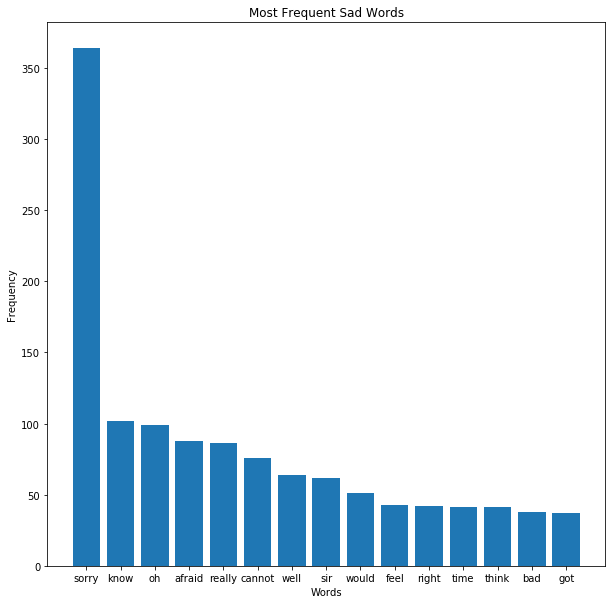

In [92]:
freq_graph(sad_freq, 'Most Frequent Sad Words', 15)

## Most Frequent Surprise Words

In [83]:
surprise_freq = emo_freq(df, 6, 20)
surprise_freq

really     546
oh         229
cannot     107
kidding     94
believe     78
know        75
like        65
would       59
wow         57
could       57
look        53
mean        52
thought     50
think       50
get         48
one         45
good        44
serious     42
going       39
never       39
dtype: int64

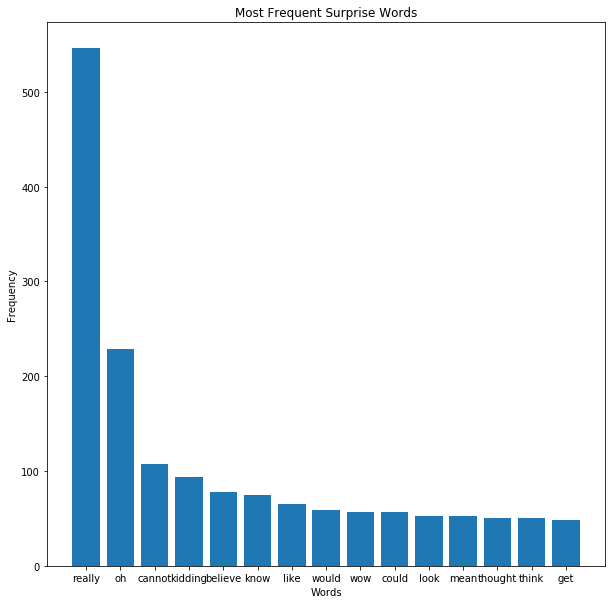

In [94]:
freq_graph(surprise_freq, 'Most Frequent Surprise Words', 15)

# <span id="3"></span>3. Class Imbalance Check
#### [Return Contents](#0)

There's a clear class imbalance issue.  The majority class of no emotion has over 85,000 instances followed by happiness with 12,900 instances followed by surprise with 1,823 instances.  This needs to be addressed.  I will plan on undersampling the no emotion and happiness to bring these classes in balance.

In [46]:
class_dist = df.groupby('emotion')['dialogue'].count()
class_dist

emotion
0    85573
1     1022
2      353
3      174
4    12885
5     1150
6     1823
Name: dialogue, dtype: int64

In [39]:
emotions = ['No emotion', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']

Text(0, 0.5, 'Number of Instances')

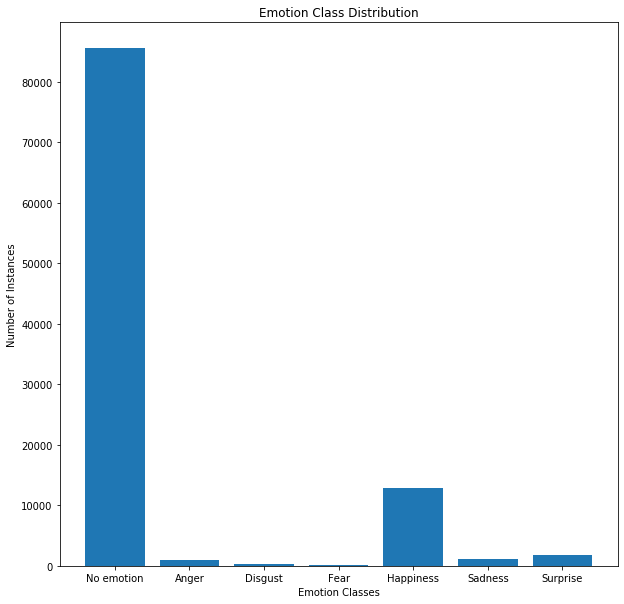

In [45]:
plt.figure(figsize=(10,10))
plt.bar(class_dist.index, class_dist['dialogue'], tick_label=emotions)
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Instances')

# <span id="4"></span>4. Checking Updated Dataset
#### [Return Contents](#0)

To address this class imbalance, I started by adding to anger, disgust, fear and sadness with text gathered from reddit comments through the PushShift API as well as the happy path sentences for the ideal user messages for the chatbot.

And here is the class balance after the updates.

In [95]:
master = pd.read_pickle('data/master_under.pickle')

In [96]:
class_dist_master = master.groupby('emotion').count()
class_dist_master

,text
emotion,
0,2500
1,3593
2,2192
3,3312
4,3792
5,3458
6,2500


Text(0, 0.5, 'Number of Instances')

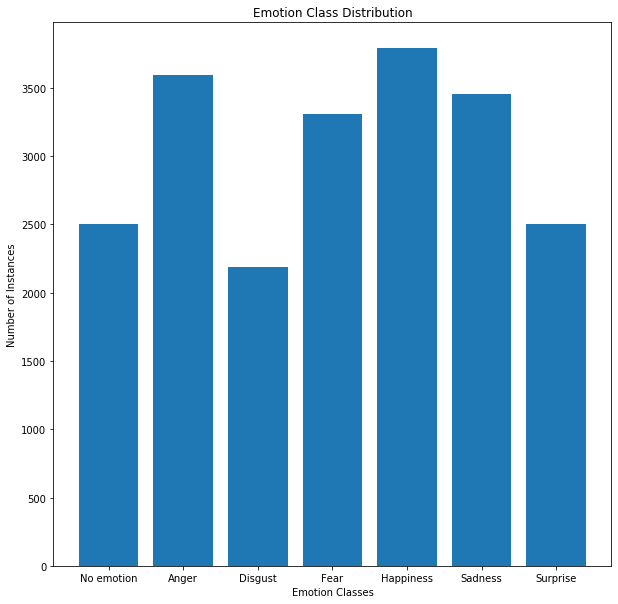

In [110]:
emotions = ['No emotion', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
plt.figure(figsize=(10,10))
plt.bar(class_dist_master.index, class_dist_master['text'], tick_label=emotions)
plt.title('Emotion Class Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Instances')

In [98]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21347 entries, 0 to 21346
Data columns (total 2 columns):
text       21347 non-null object
emotion    21347 non-null int64
dtypes: int64(1), object(1)
memory usage: 333.7+ KB


In [100]:
master['text_len'] = master.text.apply(lambda x: len(x.split(" ")))

In [104]:
master.text_len.describe()

print("There are {} utterances in total".format(master.text_len.describe()['count']))
print("The longest document has {} words".format(master.text_len.describe()['max']))
print("The shortest document has {} words".format(master.text_len.describe()['min']))
print("The average word count is {} words per utterance".format(round(master.text_len.describe()['mean'], 1)))
                                                                      

There are 21347.0 utterances in total
The longest document has 4785.0 words
The shortest document has 1.0 words
The average word count is 16.8 words per utterance


Text(0, 0.5, 'Number of texts')

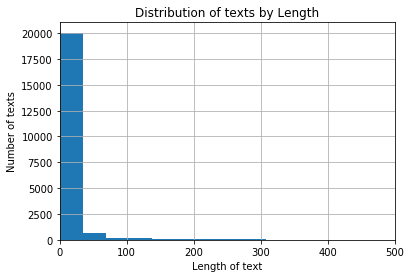

In [107]:
# examining the distribution of the description lengths
master.text_len.hist(bins = 140)
plt.xlim([0, 500])
plt.title('Distribution of texts by Length')
plt.xlabel('Length of text')
plt.ylabel('Number of texts')

In [ ]:
master_freq_angry = master.text.str.split(expand=True).stack().value_counts()
master_freq_angry[:20]